# COMP5331 Group 6 Project: Resilient k-Clustering

In [1]:
from os import mkdir, makedirs
%load_ext autoreload
%autoreload 2

## Mount Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Comp 5331/"
%ls

## Preprocess datasets

In [1]:
from src.preprocess.process_uber import process_uber
ds_path = "dataset/uber/uber-raw-data-jun14.csv"
save_path = "dataset/uber/"
process_uber(ds_path, save_path)

11/08/2024, 13:20:35: creating graph
11/08/2024, 13:20:49: matching
11/08/2024, 13:20:54: finish


In [2]:
from src.preprocess.process_geo import process_geo
ds_names = ["Brightkite", "Gowalla"]
for ds_name in ds_names:
    print(f"Processing {ds_name} dataset")
    ds_path = f"dataset/snap_standford/{ds_name}_totalCheckins.txt"
    save_path = "dataset/snap_standford/"
    process_geo(ds_path, save_path, ds_name)

Processing Brightkite dataset
11/08/2024, 13:21:00: filtering
11/08/2024, 13:21:15: matching
11/08/2024, 13:21:15: finish
Processing Gowalla dataset
11/08/2024, 13:21:15: filtering
11/08/2024, 13:21:50: matching
11/08/2024, 13:21:50: finish


In [ ]:
from src.preprocess.process_birch import process_birch
ds_name = "birch1"
ds_path = f"dataset/birch/{ds_name}.txt"
save_path = "dataset/birch"
process_birch(ds_path, save_path, ds_name)

In [ ]:
from src.preprocess.process_high_dim import process_high_dim
dims = ['032', '064', '128']

for dim in dims:
    ds_name = "dim"+dim
    ds_path = f"/dataset/high_dim/{ds_name}.txt"
    save_path = "/dataset/high_dim"
    process_high_dim(ds_path, save_path, ds_name)

### Visualize the data

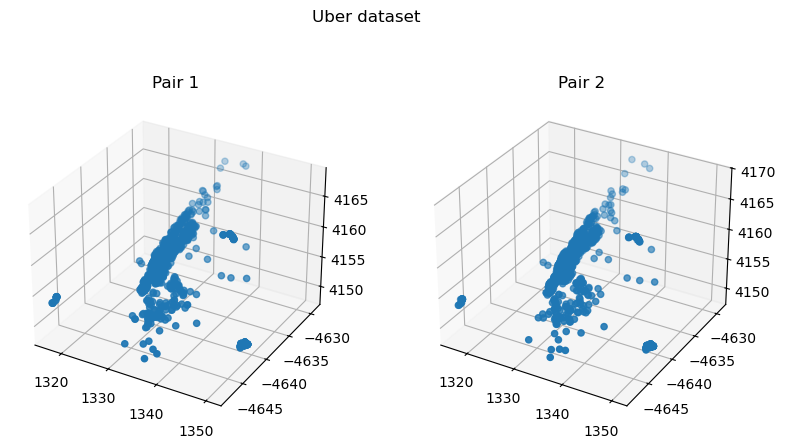

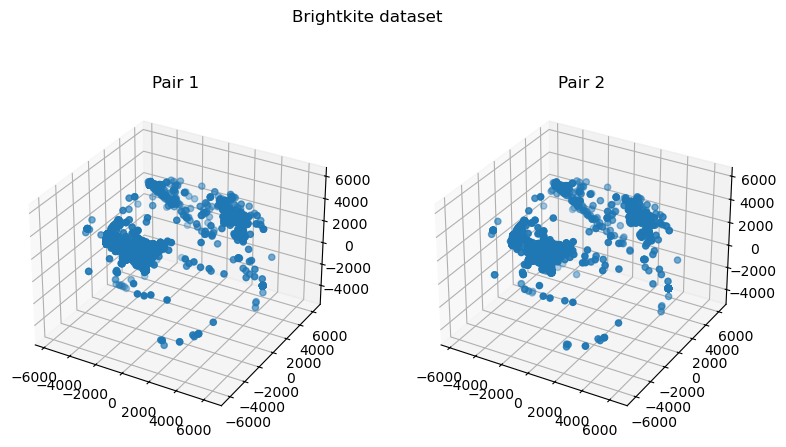

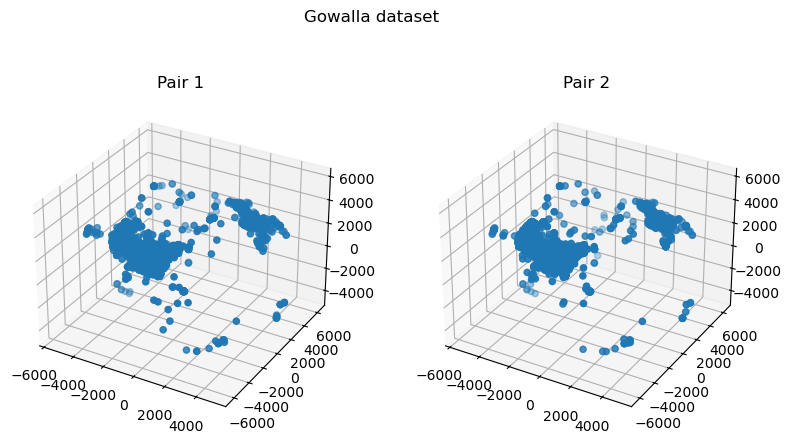

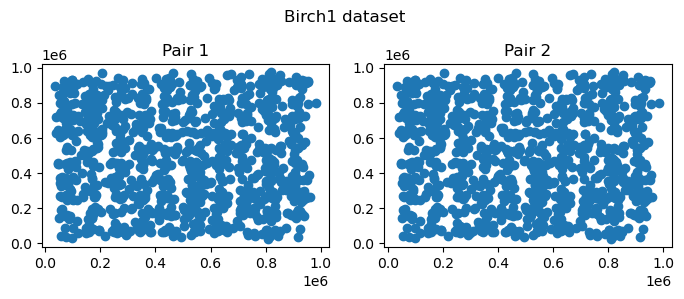

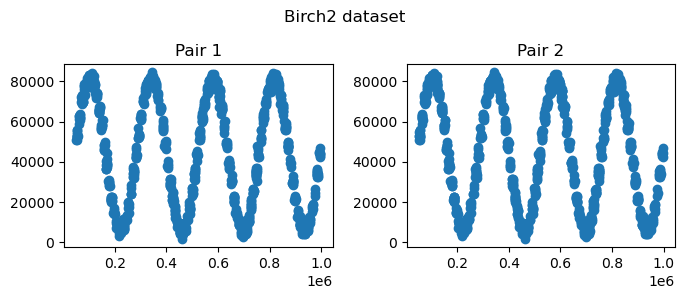

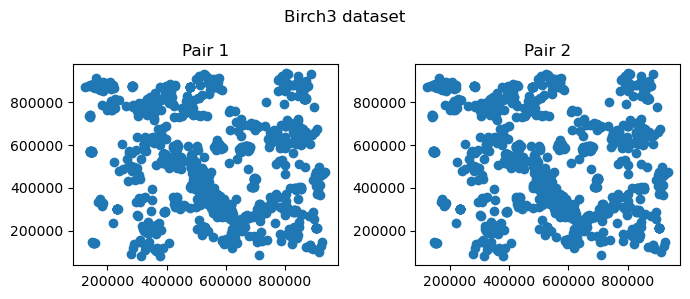

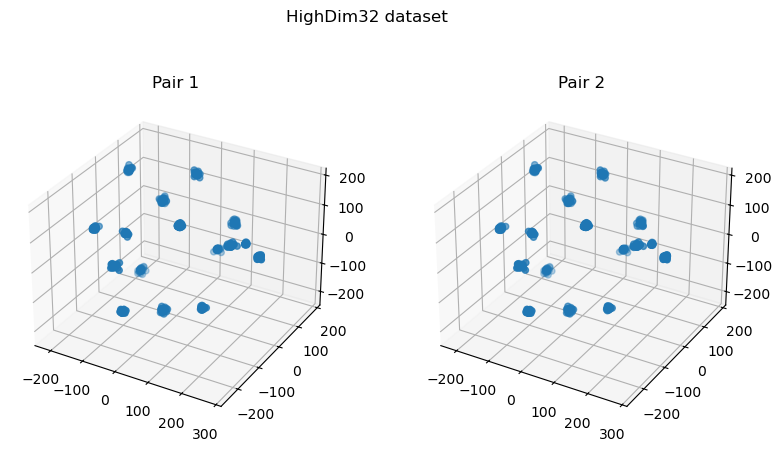

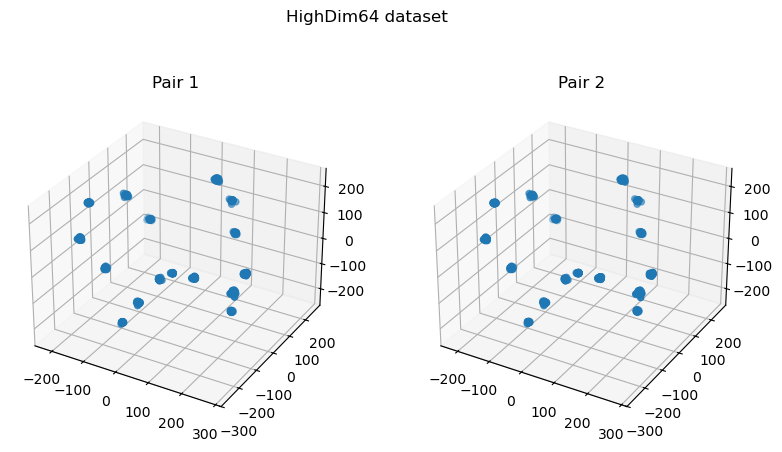

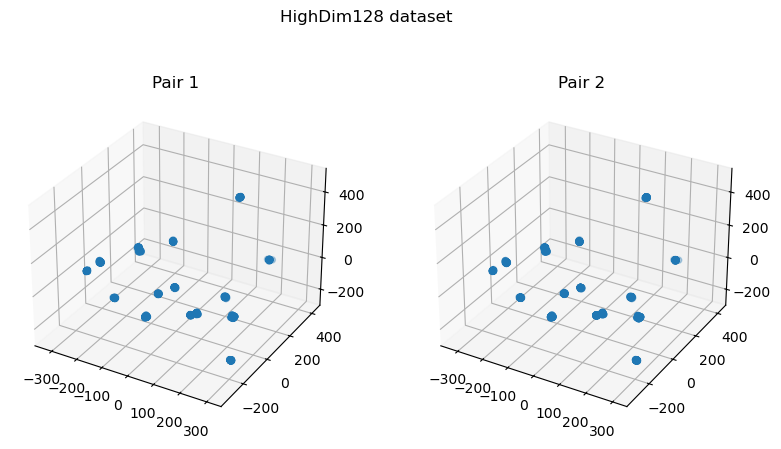

In [12]:
from src.testing.plot_helper import plot_data
from src.datasets import *
from os.path import join, isdir
from os import mkdir
ds_path = "./dataset"
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50),
           Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10)
           ]
plot_path = "./dataset/plot"
if not isdir(plot_path):
    mkdir(plot_path)
for ds in dataset:
    pair1, pair2 = ds.load()
    plot_data(pair1, pair2, plot_path, ds.name)

## Experiment

### k-resillient

In [83]:
import numpy as np
from src.resilient_k import resilient_k_center
from src.datasets import *
from os.path import join, isdir
from os import mkdir, makedirs
from src.testing.plot_helper import plot_cluster_result
import pickle
#import time

In [84]:
def experiment(ds, resilient_k_param, plot_path, result_path):
    show = True # so that only show plot once
    for algo in resilient_k_param["algorithm"]:
        for alpha in resilient_k_param["alpha"]:
            for beta in resilient_k_param["beta"]:     
                print(f"Processing {ds.name} dataset with k={ds.k}, lamb={ds.lamb}, alpha={alpha}, beta={beta}, algorithm={algo}")
                pair1, pair2 = ds.load()
                epsilon = 0.3
                model1 = resilient_k_center(pair1, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algo, exp=True)
                #start_time = time.process_time_ns()
                center1, cluster1 = model1.resilient_k_center()
                #end_time = time.process_time_ns()
                #time_taken1 = end_time - start_time
                
                model2 = resilient_k_center(pair2, k=ds.k, lamb=ds.lamb, epsilon=epsilon, alpha=alpha, beta=beta, algorithm=algo, exp=True)
                #start_time = time.process_time_ns()
                center2, cluster2 = model2.resilient_k_center()
                #end_time = time.process_time_ns()
                #time_taken2 = end_time - start_time
                
                this_result_path = join(result_path, ds.name)
                if not isdir(this_result_path):
                    mkdir(this_result_path)
                with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_{algo}({alpha}_{beta}).pickle"), 'wb') as output_file:
                    #pickle.dump((center1, cluster1, center2, cluster2, time_taken1, time_taken2), output_file)
                    pickle.dump((center1, cluster1, center2, cluster2), output_file)
                    
                pt1 = np.asarray([c[0] for c in cluster1])
                pt2 = np.asarray([c[0] for c in cluster2])
                label1 = [c[1] for c in cluster1]
                label2 = [c[1] for c in cluster2]
                
                this_plot_path = join(plot_path, ds.name)
                if not isdir(this_plot_path):
                    mkdir(this_plot_path)
                plot_cluster_result(pt1, pt2, label1, label2, this_plot_path, ds, algo, alpha, beta, show=show)
                show = False

In [85]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0],
                    "algorithm": ["gonz", "carv"]}
plot_path = "./results/plot/resilient_k"
result_path = "./results/resilient_k"
if not isdir(plot_path):
    makedirs(plot_path)
if not isdir(result_path):
    makedirs(result_path)

#### 1. Uber

Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


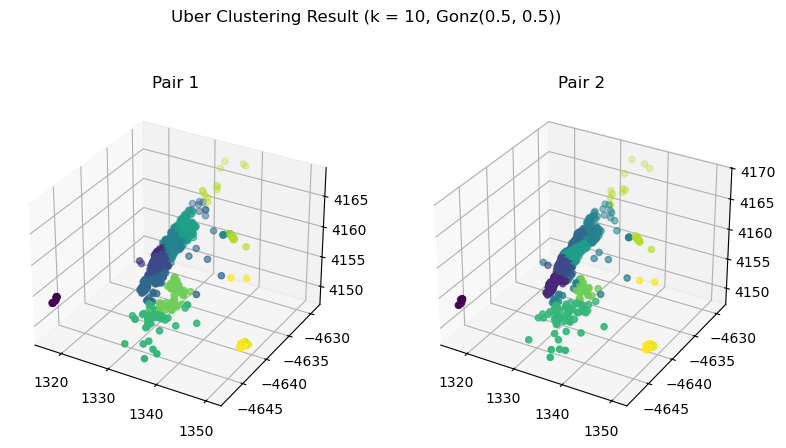

Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  12.0
Best R:  13.0
Processing Uber dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  6.0
Best R:  6.0
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  12.0
Best R:  13.0
Processing Uber dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  6.0
Best R:  6.0
Processing Uber dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

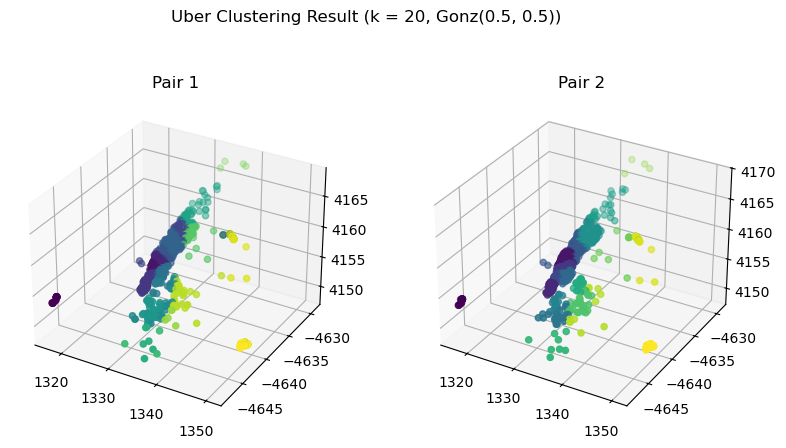

Processing Uber dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Uber dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Uber dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Uber dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  6.0
Best R:  6.0
Processing Uber dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  4.0
Best R:  4.0
Processing Uber dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  6.0
Best R:  6.0
Processing Uber dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  4.0
Best R:  4.0


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [86]:
dataset = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path)

#### 2. Brightkite

Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


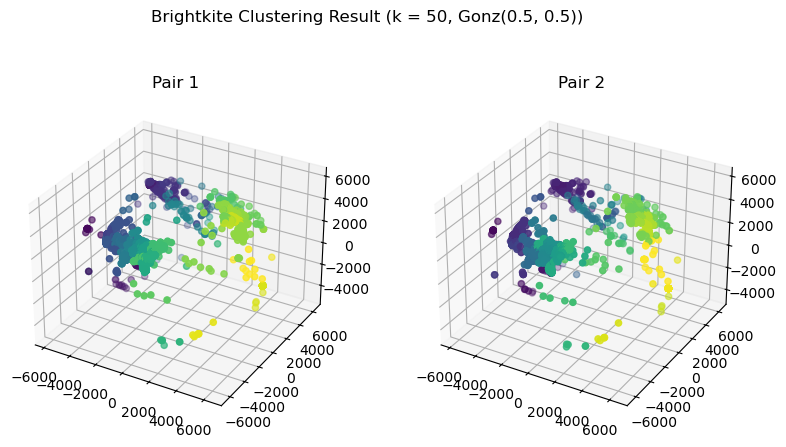

Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  2822.0
Best R:  2747.0
Processing Brightkite dataset with k=50, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  1767.0
Best R:  1636.0
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  2822.0
Best R:  2747.0
Processing Brightkite dataset with k=50, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  1767.0
Best R:  1636.0
Processing Brightkite dataset with k=100, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

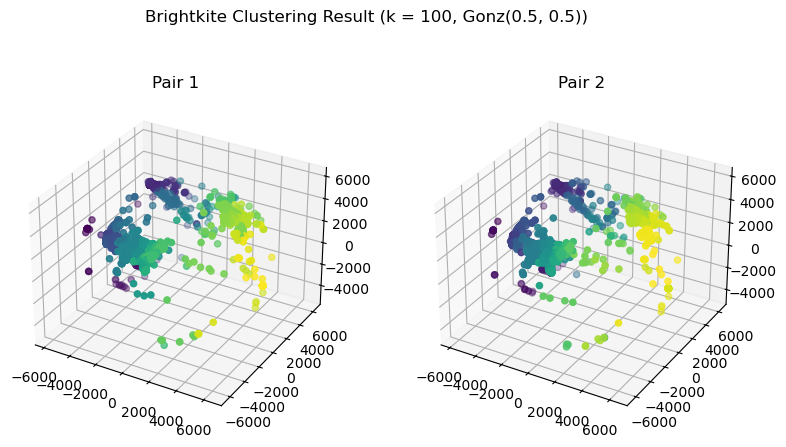

Processing Brightkite dataset with k=100, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Brightkite dataset with k=100, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Brightkite dataset with k=100, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Brightkite dataset with k=100, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  1767.0
Best R:  1636.0
Processing Brightkite dataset with k=100, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  988.0
Best R:  897.0
Processing Brightkite dataset with k=100, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  1767.0
Best R:  1636.0
Processing Brightkite dataset with k=100, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  988.0
Best R:  897.0


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [70]:
dataset = [Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=50), 
           Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.1, k=100)]#,
           #Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=50),
           #Geo(join(ds_path, "snap_standford/Gowalla_epsilon.csv"), "Gowalla", lamb=1.001, k=100)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path)

#### 3. Birch

Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


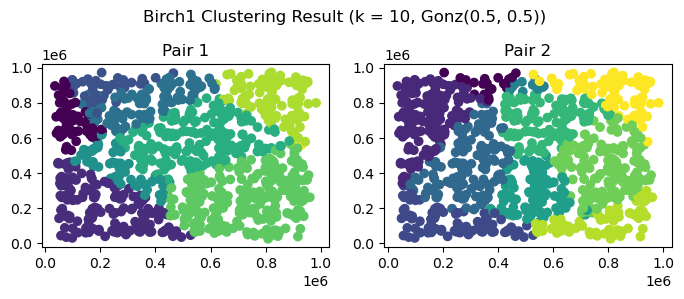

Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  389858.0
Best R:  389858.0
Processing Birch1 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  254527.0
Best R:  254526.0
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  389858.0
Best R:  389858.0
Processing Birch1 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  254527.0
Best R:  254526.0
Processing Birch1 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

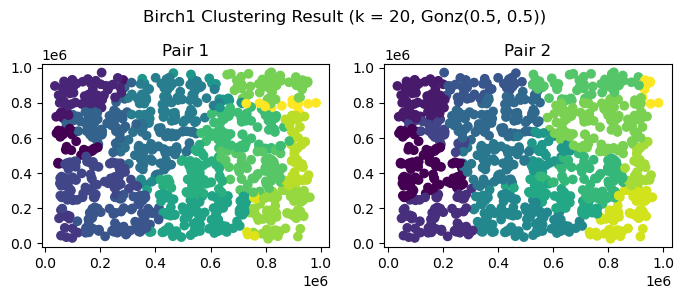

Processing Birch1 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch1 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch1 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch1 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  254527.0
Best R:  254526.0
Processing Birch1 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  177507.0
Best R:  177506.0
Processing Birch1 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  254527.0
Best R:  254526.0
Processing Birch1 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  177507.0
Best R:  177506.0
Processing Birch2 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

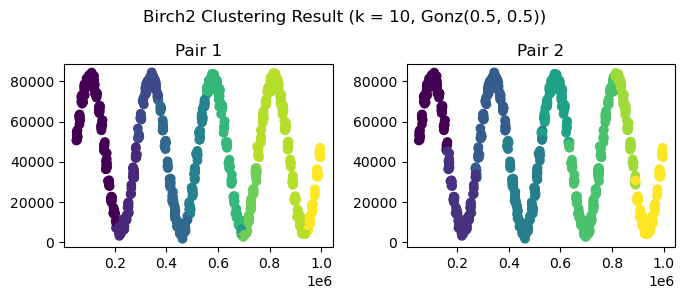

Processing Birch2 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch2 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch2 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch2 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  143325.0
Best R:  143325.0
Processing Birch2 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  79455.0
Best R:  79454.0
Processing Birch2 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  143325.0
Best R:  143325.0
Processing Birch2 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  79455.0
Best R:  79454.0
Processing Birch2 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

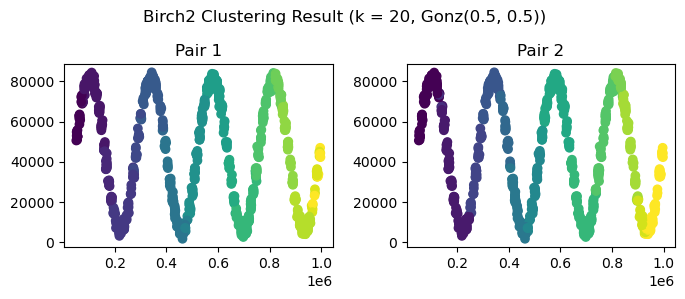

Processing Birch2 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch2 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch2 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch2 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  79455.0
Best R:  79454.0
Processing Birch2 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  41442.0
Best R:  41442.0
Processing Birch2 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  79455.0
Best R:  79454.0
Processing Birch2 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  41442.0
Best R:  41442.0
Processing Birch3 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

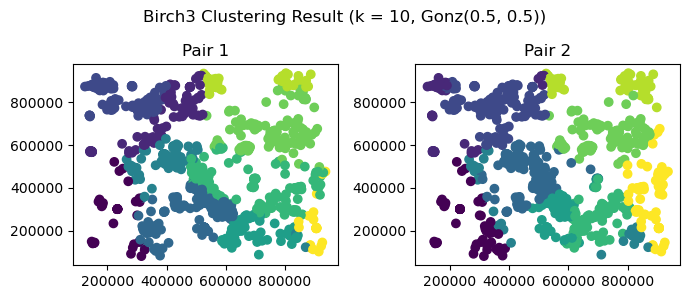

Processing Birch3 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch3 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch3 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch3 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  370604.0
Best R:  370605.0
Processing Birch3 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  235116.0
Best R:  235116.0
Processing Birch3 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  370604.0
Best R:  370605.0
Processing Birch3 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  235116.0
Best R:  235116.0
Processing Birch3 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

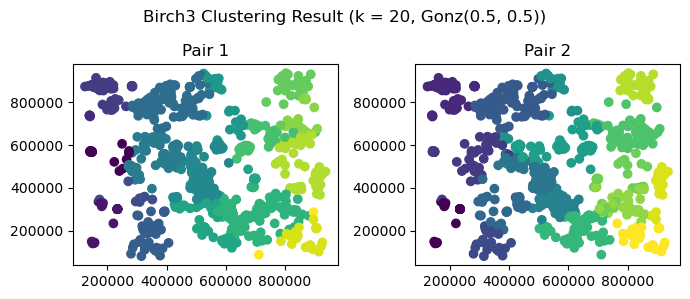

Processing Birch3 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing Birch3 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing Birch3 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing Birch3 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  235116.0
Best R:  235116.0
Processing Birch3 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  151680.0
Best R:  151681.0
Processing Birch3 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  235116.0
Best R:  235116.0
Processing Birch3 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  151680.0
Best R:  151681.0


<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

<Figure size 700x300 with 0 Axes>

In [91]:
dataset = [Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20)]

for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path)

#### 4.High dim 

Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


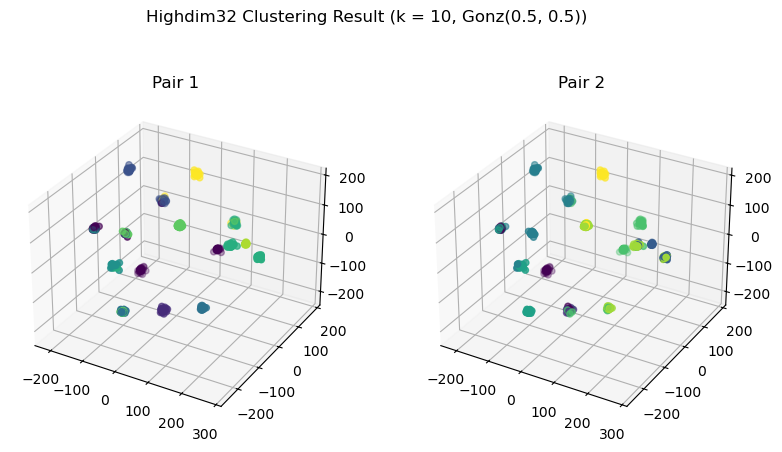

Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  426.0
Best R:  425.0
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  374.0
Best R:  374.0
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  426.0
Best R:  425.0
Processing HighDim32 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  374.0
Best R:  374.0
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

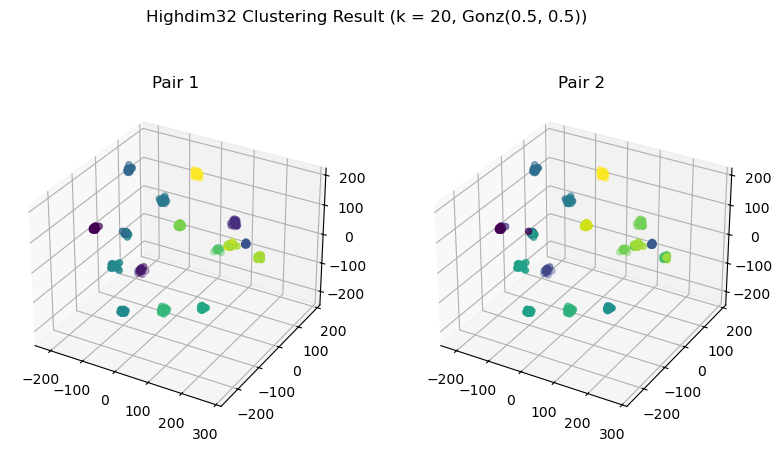

Processing HighDim32 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  374.0
Best R:  374.0
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  49.0
Best R:  49.0
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  374.0
Best R:  374.0
Processing HighDim32 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  49.0
Best R:  49.0
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

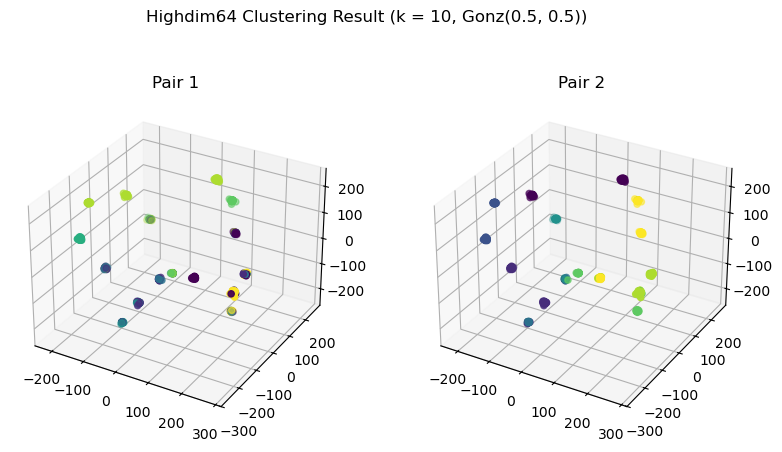

Processing HighDim64 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  604.0
Best R:  604.0
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  551.0
Best R:  551.0
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  604.0
Best R:  604.0
Processing HighDim64 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  551.0
Best R:  551.0
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

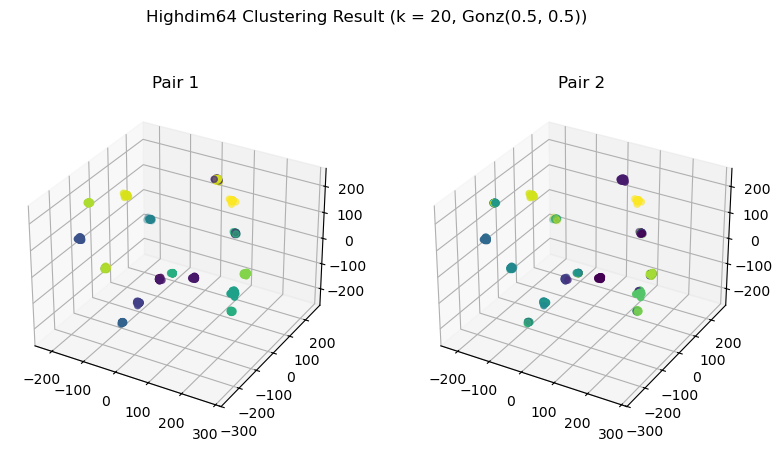

Processing HighDim64 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  551.0
Best R:  551.0
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  45.0
Best R:  46.0
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  551.0
Best R:  551.0
Processing HighDim64 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  45.0
Best R:  46.0
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

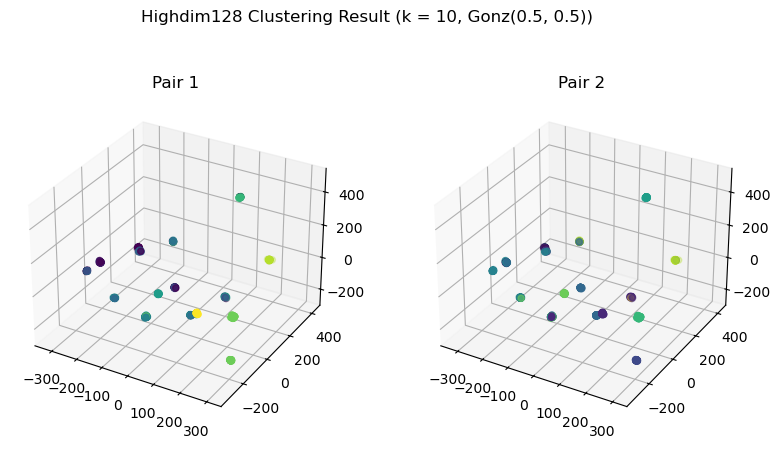

Processing HighDim128 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  856.0
Best R:  856.0
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  810.0
Best R:  810.0
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  856.0
Best R:  856.0
Processing HighDim128 dataset with k=10, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  810.0
Best R:  810.0
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=gonz


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

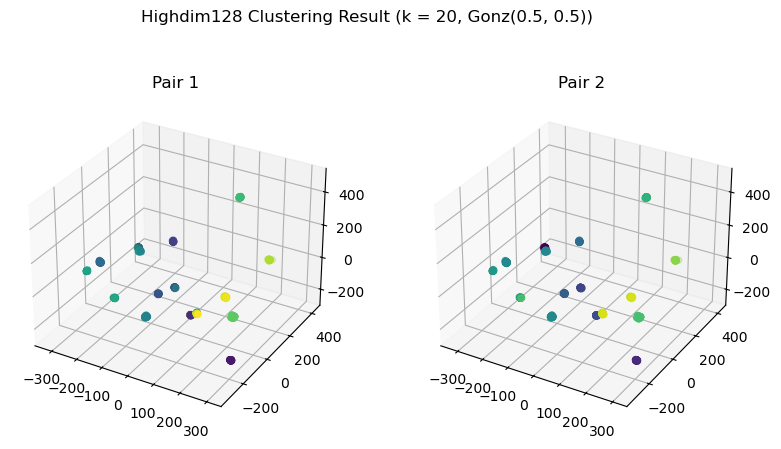

Processing HighDim128 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=gonz
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=gonz
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=gonz
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=0.5, beta=0.5, algorithm=carv
Best R:  810.0
Best R:  810.0
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=0.5, beta=1.0, algorithm=carv
Best R:  64.0
Best R:  64.0
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=1.0, beta=0.5, algorithm=carv
Best R:  810.0
Best R:  810.0
Processing HighDim128 dataset with k=20, lamb=1.1, alpha=1.0, beta=1.0, algorithm=carv
Best R:  64.0
Best R:  64.0


<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

<Figure size 960x480 with 0 Axes>

In [69]:
dataset = [HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20)]
for ds in dataset:
    experiment(ds, resilient_k_param, plot_path, result_path)

## Evalutaion

In [87]:
from src.evaluation import Metrics, Clustering
from src.testing.find_pair_assignment import find_pair_assign
from os.path import join, isdir, isfile
from os import mkdir
from src.datasets import *

In [93]:
ds_path = "./dataset"
resilient_k_param ={"alpha": [0.5, 1.0], 
                    "beta": [0.5, 1.0],
                    "algorithm": ["gonz", "carv"]}

to_eval = [Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=10),
           Uber(join(ds_path, "uber/uber_epsilon.csv"), lamb=1.1, k=20),
           # Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.001, k=50), 
           # Geo(join(ds_path, "snap_standford/Brightkite_epsilon.csv"), "Brightkite", lamb=1.001, k=100),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch1_epsilon.csv"), subset=1, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch2_epsilon.csv"), subset=2, lamb=1.1, k=20),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=10),
           Birch(join(ds_path, "birch/shrink_birch3_epsilon.csv"), subset=3, lamb=1.1, k=20), 
           # HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=10),
           # HighDim(join(ds_path, "high_dim/dim032_epsilon.csv"), dim=32, lamb=1.1, k=20),
           # HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=10),
           # HighDim(join(ds_path, "high_dim/dim064_epsilon.csv"), dim=64, lamb=1.1, k=20),
           # HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=10),
           # HighDim(join(ds_path, "high_dim/dim128_epsilon.csv"), dim=128, lamb=1.1, k=20) 
           ]
result_path = "./results"
baseline_path = join(result_path, "baseline")

### Baseline

#### 1. Gonz algorithm

In [ ]:
from src.evaluation import GonzalezAlgorithm

for ds in to_eval:
    print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
    pair1, pair2 = ds.load()
    model1 = GonzalezAlgorithm(pair1, ds.k)
    center1, cluster1 = model1.gonzalez()
    model1 = GonzalezAlgorithm(pair2, ds.k)
    center2, cluster2 = model1.gonzalez()
    
    this_result_path = join(baseline_path, "gonz")
    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_gonz_only.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)

#### 2. Carve algorithm

In [ ]:
from src.evaluation import CarvingAlgorithm

for ds in to_eval:
    print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
    pair1, pair2 = ds.load()
    
    model1 = CarvingAlgorithm(pair1)
    best_r = model1.find_minimum_R(ds.k)
    center1, cluster1 = model1.carve(best_r, ds.k)
    model2 = CarvingAlgorithm(pair2)
    best_r = model2.find_minimum_R(ds.k)
    center2, cluster2 = model2.carve(best_r, ds.k)
    
    this_result_path = join(baseline_path, "carv")
    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_carv_only.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)

#### 3. HS algorithm

In [ ]:
from src.evaluation import HSAlgorithm

for ds in to_eval:
    print(f"Processing {ds.name} dataset with k={ds.k}, algorithm=gonz_only")
    pair1, pair2 = ds.load()
    
    model1 = HSAlgorithm(pair1,ds.k)
    center1, cluster1 = model1.hs_algorithm(pair1, ds.k)
    model2 = HSAlgorithm(pair1,ds.k)
    center2, cluster2 = model2.hs_algorithm(pair2, ds.k)
    
    this_result_path = join(baseline_path, "hs")
    with open(join(this_result_path, f"{ds.name}_resilient_{ds.k}_hs_only.pickle"), 'wb') as output_file:
        pickle.dump((center1, cluster1, center2, cluster2), output_file)

### Result

In [89]:
result_path = "./results"
eval_path = join(result_path, "eval")
if not isdir(eval_path):
    mkdir(eval_path)

In [95]:
epsilon = 0.3
for ds in to_eval: 
    if isfile(join(eval_path, f"{ds.name}_resilient_k_exp_result.csv")):
        ds_result = pd.read_csv(join(eval_path, f"{ds.name}_resilient_k_exp_result.csv"))
    else:
        ds_result = pd.DataFrame() #  columns=["k", "algo", "alpha", "beta", "fraction_changed", "sol_cost_1", "sol_cost_2", "num_cluster_1", "num_cluster_2"]
    for algo in resilient_k_param["algorithm"]:
        for alpha in resilient_k_param["alpha"]:
            for beta in resilient_k_param["beta"]:    
                this_result_path = join(result_path, "resilient_k", ds.name, f"{ds.name}_resilient_{ds.k}_{algo}({alpha}_{beta}).pickle")
                this_eval_path = join(eval_path, ds.name)
                if not isdir(this_eval_path):
                    mkdir(this_eval_path)
                pair1, pair2, label1, label2 = find_pair_assign(ds, this_result_path, this_eval_path)
                metric = Metrics()
                fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=pair1, old_medoids=label1, new_points=pair2, new_medoids=label2, epsilon=epsilon)
                ds_result = pd.concat([ds_result, pd.DataFrame.from_records([{
                    "k": ds.k, "algo": f"{algo}({alpha}, {beta})", "fraction_changed": fraction_changed, "sol_cost_1": sol_cost[0], "sol_cost_2": sol_cost[1], "num_cluster_1": num_cluster[0], "num_cluster_2": num_cluster[1]
                }])], ignore_index=True)
    #             break
    #         break
    #     break
    # break

    ds_result.to_csv(join(eval_path, f"{ds.name}_resilient_k_exp_result.csv"), index=False)

In [92]:
baselines = ['gonz', 'carv', 'hs']
epsilon = 0.3
for ds in to_eval:
    if isfile(join(eval_path, f"{ds.name}_baseline_exp_result.csv")):
        ds_result = pd.read_csv(join(eval_path, f"{ds.name}_baseline_exp_result.csv"))
    else:
        ds_result = pd.DataFrame() #  columns=["k", "algo", "fraction_changed", "sol_cost_1", "sol_cost_2", "num_cluster_1", "num_cluster_2"]
    for baseline in baselines:
        this_result_path = join(baseline_path, baseline, f"{ds.name}_baseline_{ds.k}_{baseline}_only.pickle")
        this_eval_path = join(eval_path, ds.name)
        pair1, pair2, label1, label2 = find_pair_assign(ds, this_result_path, this_eval_path)
        metric = Metrics()
        fraction_changed, sol_cost, num_cluster = metric.evaluate(old_points=pair1, old_medoids=label1, new_points=pair2, new_medoids=label2, epsilon=epsilon)
        ds_result = pd.concat([ds_result, pd.DataFrame.from_records([{
            "k": ds.k, "algo": baseline, "fraction_changed": fraction_changed, "sol_cost_1": sol_cost[0], "sol_cost_2": sol_cost[1], "num_cluster_1": num_cluster[0], "num_cluster_2": num_cluster[1]
        }])], ignore_index=True)
    ds_result.to_csv(join(eval_path, f"{ds.name}_baseline_exp_result.csv"), index=False)

FileNotFoundError: [Errno 2] No such file or directory: './results\\baseline\\gonz\\Uber_baseline_10_gonz_only.pickle'

In [71]:
from src.testing.plot_helper import plot_result_bar
lamb = 1.1
to_plot = {"Uber": lamb, "Brightkite": lamb, "Birch1": lamb, "Birch2": lamb, "Birch3": lamb, "HighDim32": lamb, "HighDim64": lamb, "HighDim128": lamb}
eval_path = "results/eval"
for ds, lamb in to_plot.items():
    resilient_k_df = pd.read_csv(join(eval_path, f"{ds}_resilient_k_exp_result.csv"))
    #baseline_df = pd.read_csv(join(eval_path, f"{ds}_baseline_exp_result.csv")) 
    baseline_df = pd.DataFrame()
    plot_result_bar(resilient_k_df, baseline_df, ds, lamb)

[autoreload of src.testing.plot_helper failed: Traceback (most recent call last):
  File "D:\Users\user\anaconda3\envs\comp5331\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "D:\Users\user\anaconda3\envs\comp5331\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "D:\Users\user\anaconda3\envs\comp5331\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "D:\School\PG\2024 Fall\Comp 5331\Group project\comp5331-grp6\src\testing\plot_helper.py", line 168
    alg

FileNotFoundError: [Errno 2] No such file or directory: 'results/eval\\Uber_resilient_k_exp_result.csv'